# Scenario X Config -> score training with Random Forest Regression

In [1]:
# import os 
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as modin_pd

# import dask.dataframe as dd

import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from ad_config_search.utils import get_rows
RSEED = 50

%load_ext autoreload
%autoreload 2

## Load tables and clean data

In [2]:
# Load in data
with open("df_configs_2sectors.pl", 'rb') as f:
    config_df = pickle.load(f)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0000-S3-P0_2,efficientdet-d3,0.3,wait,sort,0.5,1,1,38.814954
1,training_0000-S3-P1_2,efficientdet-d3,0.3,wait,sort,0.5,1,1,63.692364
2,training_0000-S17-P0_2,efficientdet-d5,0.3,wait,sort,0.3,7,1,5.586837
3,training_0000-S17-P1_2,efficientdet-d5,0.3,wait,sort,0.3,7,1,25.451615
4,training_0000-S5-P0_2,efficientdet-d5,0.5,eager,sort,0.5,1,3,2.794261
...,...,...,...,...,...,...,...,...,...
681979,training_0002-S8-P1_2,efficientdet-d4,0.3,tail-aware,sort,0.5,5,5,-2.227913
681980,training_0002-S17-P0_2,efficientdet-d5,0.3,wait,sort,0.3,5,5,5.943522
681981,training_0002-S17-P1_2,efficientdet-d5,0.3,wait,sort,0.3,5,5,13.616608
681982,training_0003-S1-P0_2,efficientdet-d6,0.3,eager,sort,0.5,3,3,-6.908044


In [3]:
config_df = config_df[config_df["D-seq-pol"] != "infinite"]  # filter out infinite runs
config_df["D-conf"] = config_df["D-conf"].astype(float)
config_df["T-min-iou"] = config_df["T-min-iou"].astype(float)
config_df["T-max-age"] = config_df["T-max-age"].astype(int)
config_df["T-every-nth-det"] = config_df["T-every-nth-det"].astype(int)
config_df["score"] = config_df["score"].astype(float)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0000-S3-P0_2,efficientdet-d3,0.3,wait,sort,0.5,1,1,38.814954
1,training_0000-S3-P1_2,efficientdet-d3,0.3,wait,sort,0.5,1,1,63.692364
2,training_0000-S17-P0_2,efficientdet-d5,0.3,wait,sort,0.3,7,1,5.586837
3,training_0000-S17-P1_2,efficientdet-d5,0.3,wait,sort,0.3,7,1,25.451615
4,training_0000-S5-P0_2,efficientdet-d5,0.5,eager,sort,0.5,1,3,2.794261
...,...,...,...,...,...,...,...,...,...
681979,training_0002-S8-P1_2,efficientdet-d4,0.3,tail-aware,sort,0.5,5,5,-2.227913
681980,training_0002-S17-P0_2,efficientdet-d5,0.3,wait,sort,0.3,5,5,5.943522
681981,training_0002-S17-P1_2,efficientdet-d5,0.3,wait,sort,0.3,5,5,13.616608
681982,training_0003-S1-P0_2,efficientdet-d6,0.3,eager,sort,0.5,3,3,-6.908044


In [4]:
def get_oracle_k_10_configs(configs_scores, train_scenarios):
    from ad_config_search.utils import (shift_rows_back_one, get_rows,
                                    get_condensed_policy)
    import json
    scenario_groupby = configs_scores.groupby([
        configs_scores["run"].map(lambda x: x.split("-P")[0])
    ])
    configs_scores_train = \
        pd.concat([rows for scenario, rows in scenario_groupby
                   if scenario in train_scenarios])
    oracle_k_10_policy = get_condensed_policy(configs_scores_train, k=10)
    oracle_k_10_configs = \
        [json.loads(s) for s in
         np.unique([json.dumps(c) for c in oracle_k_10_policy.values()])]
    return oracle_k_10_configs

In [5]:
from ad_config_search.rforest_utils import split_scenarios

In [6]:
train_scenarios, test_scenarios = split_scenarios(config_df["run"].map(lambda x: x.split("-P")[0]).unique(), 1/3)

In [7]:
oracle_k_10_configs = get_oracle_k_10_configs(config_df, train_scenarios)

100%|██████████| 198/198 [00:03<00:00, 50.61it/s]


In [8]:
config_df = pd.concat([get_rows(config_df, c) for c in tqdm(oracle_k_10_configs)])

100%|██████████| 24/24 [00:01<00:00, 15.90it/s]


In [9]:
print(np.sum(np.isnan(config_df["score"])))
print(np.sum(np.isinf(config_df["score"])))
config_df = config_df[config_df["score"].notna()]
config_df = config_df[~config_df["score"].isin([-np.inf])]
print(np.sum(np.isnan(config_df["score"])))
print(np.sum(np.isinf(config_df["score"])))

0
0
0
0


In [10]:
# 148 scenarios * 50 configs * 5 sections in scenario = 37000
# 37000 - 337 - 213 = 36450
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
564,training_0000-S6-P0_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,7.811588
565,training_0000-S6-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,29.494673
1490,training_0000-S10-P0_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,30.035583
1491,training_0000-S10-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,11.420026
1568,training_0000-S18-P0_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,-0.270867
...,...,...,...,...,...,...,...,...,...
672733,training_0003-S21-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,34.874394
675152,training_0002-S18-P0_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,31.527695
675153,training_0002-S18-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,35.270993
679070,training_0001-S20-P0_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,59.246921


In [12]:
scenario_feats_df.columns

Index(['avg_bbox_longevity', '90p_bbox_longevity', '10p_bbox_longevity',
       'avg_num_bboxes', '90p_num_bboxes', '10p_num_bboxes', 'avg_bbox_size',
       '90p_bbox_size', '10p_bbox_size', 'avg_bbox_speed', '90p_bbox_speed',
       '10p_bbox_speed', 'avg_ego_speed', '90p_ego_speed', '10p_ego_speed',
       'time_of_day', 'weather', 'location', 'scenario_name', 'pastC-D-model',
       'pastC-D-conf', 'pastC-D-seq-pol', 'pastC-T-min-iou', 'pastC-T-max-age',
       'pastC-T-every-nth-det'],
      dtype='object')

### Join tables, one-hot encode

In [18]:
# scenario_feats_df misses all -P0_5 scenarios
# config_df misses one scenario with nans or -infs in it
x = set(config_df["run"])
y = set(scenario_feats_df["scenario_name"])
x.difference(y), y.difference(x)

({'training_0000-S0-P0_2',
  'training_0000-S1-P0_2',
  'training_0000-S10-P0_2',
  'training_0000-S11-P0_2',
  'training_0000-S12-P0_2',
  'training_0000-S13-P0_2',
  'training_0000-S14-P0_2',
  'training_0000-S15-P0_2',
  'training_0000-S16-P0_2',
  'training_0000-S17-P0_2',
  'training_0000-S18-P0_2',
  'training_0000-S19-P0_2',
  'training_0000-S2-P0_2',
  'training_0000-S20-P0_2',
  'training_0000-S21-P0_2',
  'training_0000-S22-P0_2',
  'training_0000-S23-P0_2',
  'training_0000-S3-P0_2',
  'training_0000-S4-P0_2',
  'training_0000-S5-P0_2',
  'training_0000-S6-P0_2',
  'training_0000-S7-P0_2',
  'training_0000-S8-P0_2',
  'training_0000-S9-P0_2',
  'training_0001-S0-P0_2',
  'training_0001-S1-P0_2',
  'training_0001-S10-P0_2',
  'training_0001-S11-P0_2',
  'training_0001-S12-P0_2',
  'training_0001-S13-P0_2',
  'training_0001-S14-P0_2',
  'training_0001-S15-P0_2',
  'training_0001-S16-P0_2',
  'training_0001-S17-P0_2',
  'training_0001-S18-P0_2',
  'training_0001-S19-P0_2',
  't

In [19]:
joined_df = config_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df", how="inner")
# assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
# assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,...,90p_ego_speed,10p_ego_speed,time_of_day,location,pastC-D-model,pastC-D-conf,pastC-D-seq-pol,pastC-T-min-iou,pastC-T-max-age,pastC-T-every-nth-det
training_0000-S0-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,21.093077,9.617647,19.2,...,5.802231,4.304792,Day,location_sf,efficientdet-d1,0.3,wait,0.5,1,3
training_0000-S0-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,21.093077,18.894737,52.4,...,5.802231,4.304792,Day,location_sf,efficientdet-d2,0.5,wait,0.2,1,1
training_0000-S0-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,21.093077,21.800000,54.8,...,5.802231,4.304792,Day,location_sf,efficientdet-d3,0.3,eager,0.1,3,1
training_0000-S0-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,21.093077,13.225806,51.0,...,5.802231,4.304792,Day,location_sf,efficientdet-d3,0.5,wait,0.1,1,1
training_0000-S0-P1_2,efficientdet-d1,0.3,wait,sort,0.5,1,3,21.093077,20.909091,61.2,...,5.802231,4.304792,Day,location_sf,efficientdet-d4,0.3,eager,0.1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,33.894607,13.226667,42.8,...,10.122393,8.241427,Day,location_phx,efficientdet-d7x,0.3,eager,0.1,1,1
training_0005-S9-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,33.894607,23.204082,59.8,...,10.122393,8.241427,Day,location_phx,efficientdet-d7x,0.3,eager,0.1,7,1
training_0005-S9-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,33.894607,22.895833,52.5,...,10.122393,8.241427,Day,location_phx,efficientdet-d7x,0.3,tail-aware,0.1,7,3
training_0005-S9-P1_2,efficientdet-d7x,0.5,wait,sort,0.1,5,1,33.894607,17.016129,48.7,...,10.122393,8.241427,Day,location_phx,efficientdet-d7x,0.5,wait,0.1,3,1


In [20]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df["scenario_name"] = joined_df.index.map(lambda x: "-".join(x.split("-")[:2]))
joined_df

,D-conf,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,...,pastC-D-model__efficientdet-d4,pastC-D-model__efficientdet-d5,pastC-D-model__efficientdet-d6,pastC-D-model__efficientdet-d7,pastC-D-model__efficientdet-d7x,pastC-D-seq-pol__eager,pastC-D-seq-pol__infinite,pastC-D-seq-pol__tail-aware,pastC-D-seq-pol__wait,scenario_name
training_0000-S0-P1_2,0.3,0.5,1,3,21.093077,9.617647,19.2,3.0,3.27,5.0,...,0,0,0,0,0,0,0,0,1,training_0000-S0
training_0000-S0-P1_2,0.3,0.5,1,3,21.093077,18.894737,52.4,1.0,3.59,5.0,...,0,0,0,0,0,0,0,0,1,training_0000-S0
training_0000-S0-P1_2,0.3,0.5,1,3,21.093077,21.800000,54.8,2.0,4.36,6.0,...,0,0,0,0,0,1,0,0,0,training_0000-S0
training_0000-S0-P1_2,0.3,0.5,1,3,21.093077,13.225806,51.0,1.0,4.10,6.0,...,0,0,0,0,0,0,0,0,1,training_0000-S0
training_0000-S0-P1_2,0.3,0.5,1,3,21.093077,20.909091,61.2,2.0,4.60,6.0,...,1,0,0,0,0,1,0,0,0,training_0000-S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P1_2,0.5,0.1,5,1,33.894607,13.226667,42.8,1.0,9.92,14.0,...,0,0,0,0,1,1,0,0,0,training_0005-S9
training_0005-S9-P1_2,0.5,0.1,5,1,33.894607,23.204082,59.8,4.0,11.37,16.0,...,0,0,0,0,1,1,0,0,0,training_0005-S9
training_0005-S9-P1_2,0.5,0.1,5,1,33.894607,22.895833,52.5,4.0,10.99,16.0,...,0,0,0,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P1_2,0.5,0.1,5,1,33.894607,17.016129,48.7,2.0,10.55,15.0,...,0,0,0,0,1,0,0,0,1,training_0005-S9


## Prep training

In [21]:
# Extract the labels
labels = np.array(joined_df.pop('score'))

### Scenario examples are fairly balanced, so we just do train-test and cross-v splits across scenario boundaries

<AxesSubplot:xlabel='scenario_name', ylabel='Count'>

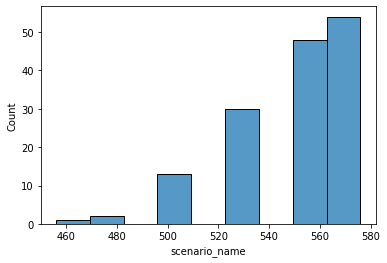

In [22]:
counts = joined_df["scenario_name"].value_counts()
sns.histplot(counts)

#### Manual train-test split across scenario boundaries

In [23]:
import random
# unique_scenarios = list(joined_df["scenario_name"].unique())
# unique_scenarios = sorted(unique_scenarios)
# random.shuffle(unique_scenarios, random=lambda: 0.43)
# train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
# test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df["scenario_name"].isin(train_scenarios)], labels[joined_df["scenario_name"].isin(train_scenarios)]
test, test_labels = joined_df[joined_df["scenario_name"].isin(test_scenarios)], labels[joined_df["scenario_name"].isin(test_scenarios)]

In [24]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

In [25]:
train = train.drop(columns=["scenario_name"])
test = test.drop(columns=["scenario_name"])

#### Automated cross-validation splitter across scenario boundaries

In [26]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['D-conf',
  'T-min-iou',
  'T-max-age',
  'T-every-nth-det',
  'avg_bbox_longevity',
  '90p_bbox_longevity',
  '10p_bbox_longevity',
  'avg_num_bboxes',
  '90p_num_bboxes',
  '10p_num_bboxes',
  'avg_bbox_size',
  '90p_bbox_size',
  '10p_bbox_size',
  'avg_bbox_speed',
  '90p_bbox_speed',
  '10p_bbox_speed',
  'avg_ego_speed',
  '90p_ego_speed',
  '10p_ego_speed',
  'pastC-D-conf',
  'pastC-T-min-iou',
  'pastC-T-max-age',
  'pastC-T-every-nth-det',
  'D-model__efficientdet-d1',
  'D-model__efficientdet-d2',
  'D-model__efficientdet-d3',
  'D-model__efficientdet-d4',
  'D-model__efficientdet-d5',
  'D-model__efficientdet-d6',
  'D-model__efficientdet-d7',
  'D-model__efficientdet-d7x',
  'D-seq-pol__eager',
  'D-seq-pol__tail-aware',
  'D-seq-pol__wait',
  'T-model__sort',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf',
  'pastC-D-model__efficientdet-d1',
  'pastC-D-model__e

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [27]:
# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=1600, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [28]:
from scipy.stats import loguniform, randint

In [29]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [30]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6714.,  962.,  578.,  423.,  324.,  263.,  232.,  186.,  144.,
         174.]),
 array([0.00010019, 0.01008606, 0.02007194, 0.03005781, 0.04004369,
        0.05002956, 0.06001544, 0.07000131, 0.07998719, 0.08997306,
        0.09995894]),
 <BarContainer object of 10 artists>)

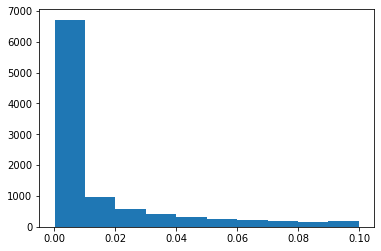

In [31]:
import matplotlib.pyplot as plt
plt.hist(x)

In [32]:
x = randint(3,10).rvs(size=10000)

In [33]:
import matplotlib.pyplot as plt
np.bincount(x)

array([   0,    0,    0, 1460, 1444, 1414, 1390, 1430, 1431, 1431])

In [34]:
# 11:19am start

In [35]:
from ad_config_search.rforest_utils import ScenarioAwareCVSplitter

In [36]:
%%time
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 25),
    "max_features": randint(2, 24),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2)
}, cv=ScenarioAwareCVSplitter(n_splits=5, shuffle=True, random_state=RSEED), n_iter=100)
clf.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.3s finished
[Parallel(n_jobs=72)]: Using backend ThreadingBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=72)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=72)]: Using backend ThreadingBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=72)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n

KeyboardInterrupt: 

In [67]:
# per-scenario grained
clf.cv_results_

{'mean_fit_time': array([ 13.60228038,  12.93668113,  21.48796592,  98.98848577,
         34.54982977,   7.34225445,  89.2219131 ,   3.68464241,
         64.02153502,  18.71725492,  13.99185929,   2.66076665,
         11.28685107,  40.98371506,  71.46419921,  85.74601936,
         48.78321257,   3.51353326,  26.80216155,   5.647715  ,
         33.33482609, 112.43242307,   3.74420805,   7.63872447,
         20.99711604,   8.38579674,  95.16363378,  53.8401691 ,
         13.26439118,  12.71113253,  38.27607374,  20.10103354,
         71.81475191,   2.25435419,  13.90642419,   4.86666322,
         16.55850272,  29.0594656 ,   9.71992049,  47.0719624 ,
         43.0640213 ,  48.636937  ,  16.35087223,   4.86734571,
         23.72788291,  85.51852241,   3.94009571,  23.88549757,
          6.52997975,  32.61102004,  21.16809111,  43.69443011,
         30.87174487,   8.08460059,  30.54601126,  39.0603941 ,
          8.08694005,  12.38469634,   8.98359962,  14.83995461,
         17.73350487,  

In [37]:
# per-scenario grained
clf.best_estimator_

RandomForestRegressor(max_depth=10, max_features=2,
                      min_impurity_decrease=0.0007985444795706414,
                      n_estimators=400, n_jobs=-1, random_state=50, verbose=1)

In [36]:
from ad_config_search.rforest_training import get_stats_and_save, MetadataV1
metadata = MetadataV1(model_type="RF", env_window_size="10s", time_strategy="past-1-step", env_feats="pipeline-output-v1",
                 stride_strategy="window-size", other="condensed-k_10")
get_stats_and_save(clf.best_estimator_, train, train_labels, test, test_labels, metadata)

Feature importance
[('avg_ego_speed', 0.10060545689130877), ('90p_ego_speed', 0.09373166530428312), ('10p_ego_speed', 0.09284710645253509), ('avg_num_bboxes', 0.05125348513407469), ('avg_bbox_size', 0.05074919711723346), ('90p_bbox_size', 0.04796025555194296), ('10p_bbox_size', 0.047665348053738676), ('90p_num_bboxes', 0.04599644294731912), ('avg_bbox_longevity', 0.04377351607020977), ('90p_bbox_speed', 0.04195590324736342), ('10p_bbox_speed', 0.03780540546948113), ('90p_bbox_longevity', 0.03761303715161292), ('avg_bbox_speed', 0.03712510698781502), ('location__location_sf', 0.03591353848099939), ('10p_num_bboxes', 0.03385909464672673), ('location__location_phx', 0.028921446069237446), ('T-min-iou', 0.02525417724632576), ('T-every-nth-det', 0.024140856567758513), ('10p_bbox_longevity', 0.017301153231367963), ('D-model__efficientdet-d1', 0.016519290047809526), ('time_of_day__Dawn/Dusk', 0.015728389609804615), ('time_of_day__Day', 0.012132093806849237), ('T-max-age', 0.007734640096754072

[Parallel(n_jobs=72)]: Using backend ThreadingBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=72)]: Done 400 out of 400 | elapsed:    0.1s finished


train score 0.6548930313603378
test score 0.14118342750260382


[Parallel(n_jobs=72)]: Using backend ThreadingBackend with 72 concurrent workers.
[Parallel(n_jobs=72)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=72)]: Done 400 out of 400 | elapsed:    0.1s finished


{'model': RandomForestRegressor(max_depth=10, max_features=2,
                       min_impurity_decrease=0.0007985444795706414,
                       n_estimators=400, n_jobs=-1, random_state=50, verbose=1),
 'train':                        D-conf  T-min-iou  T-max-age  T-every-nth-det  \
 training_0000-S7-P1_2     0.3        0.5          1                3   
 training_0000-S7-P1_2     0.3        0.5          1                3   
 training_0000-S7-P1_2     0.3        0.5          1                3   
 training_0000-S7-P1_2     0.3        0.5          1                3   
 training_0000-S7-P1_2     0.3        0.5          1                3   
 ...                       ...        ...        ...              ...   
 training_0005-S9-P1_2     0.5        0.1          5                1   
 training_0005-S9-P1_2     0.5        0.1          5                1   
 training_0005-S9-P1_2     0.5        0.1          5                1   
 training_0005-S9-P1_2     0.5        0.1         

## Training

In [69]:
# Create the model with 100 trees
model = RandomForestRegressor(
max_depth=22, max_features=3,
                      min_impurity_decrease=0.00020630406970744498,
                      n_estimators=400,
    random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   13.3s finished


RandomForestRegressor(max_depth=22, max_features=3,
                      min_impurity_decrease=0.00020630406970744498,
                      n_estimators=400, n_jobs=-1, random_state=50, verbose=1)

In [70]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('avg_ego_speed', 0.08989833412757382),
 ('90p_ego_speed', 0.08752906198333461),
 ('10p_ego_speed', 0.0853745814201667),
 ('90p_bbox_size', 0.05924558360526142),
 ('avg_bbox_size', 0.05895139057409128),
 ('10p_bbox_size', 0.05886101829206477),
 ('avg_num_bboxes', 0.04848759276241036),
 ('location__location_other', 0.04482419055161405),
 ('10p_bbox_speed', 0.0444110904954417),
 ('avg_bbox_speed', 0.043061183225135205),
 ('90p_bbox_speed', 0.04200334311824426),
 ('90p_num_bboxes', 0.03412238340588819),
 ('10p_num_bboxes', 0.0307827435594374),
 ('90p_bbox_longevity', 0.03075181688945523),
 ('avg_bbox_longevity', 0.029724947652005885),
 ('location__location_sf', 0.02537792066200684),
 ('T-max-age', 0.016547044772792736),
 ('location__location_phx', 0.01612024351671874),
 ('10p_bbox_longevity', 0.015608259795287042),
 ('D-model__efficientdet-d7x', 0.014417292353086168),
 ('T-every-nth-det', 0.014060539286897038),
 ('D-model__efficientdet-d2', 0.012290408287680436),
 ('time_of_day__Day', 0.

In [71]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 32026
Average maximum depth 22


In [72]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_score = model.score(train, train_labels)
print("train score", train_score)

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
test_score = model.score(test, test_labels)
print("test score", test_score)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.3s finished


train score 0.9388166248414801


[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.


test score 0.11951607726307734


[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished


In [73]:
model_type = "RF"
env_window = "40"
time = "1-step-past"
env_feats = "pipeline-output-v1"
dictionary = {
    "model": model,
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "test_labels": test_labels,
    "metadata": "condensed config space"
}
with open("model={}__env-window={}__time={}__env-feats={}__te={:.2f}.pl".format(model_type, env_window, time, env_feats, test_score), 'wb') as f:
    pickle.dump(dictionary, f)

## Using trained model to get best config and saving

In [74]:
train_copy = train.copy()
train_copy["ground_truth"] = train_labels
test_copy = test.copy()
test_copy["ground_truth"] = test_labels

In [75]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    0.7s finished


In [76]:
train.index.unique()

Index(['training_0000-S7-P1_5', 'training_0000-S7-P2_5',
       'training_0000-S7-P3_5', 'training_0000-S7-P4_5',
       'training_0000-S8-P1_5', 'training_0000-S8-P2_5',
       'training_0000-S8-P3_5', 'training_0000-S8-P4_5',
       'training_0000-S9-P1_5', 'training_0000-S9-P2_5',
       ...
       'training_0005-S7-P3_5', 'training_0005-S7-P4_5',
       'training_0005-S8-P1_5', 'training_0005-S8-P2_5',
       'training_0005-S8-P3_5', 'training_0005-S8-P4_5',
       'training_0005-S9-P1_5', 'training_0005-S9-P2_5',
       'training_0005-S9-P3_5', 'training_0005-S9-P4_5'],
      dtype='object', length=387)

In [77]:
test.index.unique()

Index(['training_0000-S0-P1_5', 'training_0000-S0-P2_5',
       'training_0000-S0-P3_5', 'training_0000-S0-P4_5',
       'training_0000-S1-P1_5', 'training_0000-S1-P2_5',
       'training_0000-S1-P3_5', 'training_0000-S1-P4_5',
       'training_0000-S10-P1_5', 'training_0000-S10-P2_5',
       ...
       'training_0005-S19-P3_5', 'training_0005-S19-P4_5',
       'training_0005-S23-P1_5', 'training_0005-S23-P2_5',
       'training_0005-S23-P3_5', 'training_0005-S23-P4_5',
       'training_0005-S6-P1_5', 'training_0005-S6-P2_5',
       'training_0005-S6-P3_5', 'training_0005-S6-P4_5'],
      dtype='object', length=196)

In [78]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [79]:
to_predict = test_copy

In [80]:
best_predicted_configs = pd.DataFrame([rows.iloc[rows["prediction"].argmax()] for run_name, rows in to_predict.groupby(["run_name"])])

In [81]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,pastC-D-model__efficientdet-d6,pastC-D-model__efficientdet-d7,pastC-D-model__efficientdet-d7x,pastC-D-seq-pol__eager,pastC-D-seq-pol__infinite,pastC-D-seq-pol__tail-aware,pastC-D-seq-pol__wait,ground_truth,prediction,run_name
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,0,0,0,1,0,0,0,40.555556,58.102445,training_0000-S0-P1_5
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,0,0,0,0,0,1,0,46.641075,50.849488,training_0000-S0-P2_5
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,0,0,0,0,0,1,0,58.150852,51.422571,training_0000-S0-P3_5
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,0,0,0,0,0,1,0,68.900804,53.832809,training_0000-S0-P4_5
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,0,0,0,0,0,1,0,21.558442,39.125896,training_0000-S1-P1_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,0,0,1,1,0,0,0,75.000000,38.425636,training_0005-S23-P4_5
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,0,1,0,0,0,0,1,15.147265,22.782569,training_0005-S6-P1_5
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,0,1,0,0,0,1,0,14.735658,23.814850,training_0005-S6-P2_5
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,0,1,0,1,0,0,0,25.144509,25.629115,training_0005-S6-P3_5


In [82]:
parent_columns = set([c.split("__")[0] for c in best_predicted_configs.columns if "__" in c])
for pc in parent_columns:
    ccs = list(filter(lambda cc: cc.startswith(pc), best_predicted_configs.columns))
    rows = best_predicted_configs[ccs]
    rows.columns = [cc.split("__")[1] for cc in ccs]
    best_predicted_configs[pc] = rows.idxmax(axis=1)
    best_predicted_configs = best_predicted_configs.drop(columns=ccs)

In [83]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,ground_truth,prediction,run_name,T-model,pastC-D-seq-pol,D-model,time_of_day,D-seq-pol,location,pastC-D-model
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,40.555556,58.102445,training_0000-S0-P1_5,sort,eager,efficientdet-d6,Day,eager,location_sf,efficientdet-d2
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,46.641075,50.849488,training_0000-S0-P2_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,58.150852,51.422571,training_0000-S0-P3_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,68.900804,53.832809,training_0000-S0-P4_5,sort,tail-aware,efficientdet-d5,Day,wait,location_sf,efficientdet-d1
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,21.558442,39.125896,training_0000-S1-P1_5,sort,tail-aware,efficientdet-d5,Day,tail-aware,location_sf,efficientdet-d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,75.000000,38.425636,training_0005-S23-P4_5,sort,eager,efficientdet-d4,Day,tail-aware,location_phx,efficientdet-d7x
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,15.147265,22.782569,training_0005-S6-P1_5,sort,wait,efficientdet-d4,Night,wait,location_phx,efficientdet-d7
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,14.735658,23.814850,training_0005-S6-P2_5,sort,tail-aware,efficientdet-d4,Night,wait,location_phx,efficientdet-d7
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,25.144509,25.629115,training_0005-S6-P3_5,sort,eager,efficientdet-d4,Night,wait,location_phx,efficientdet-d7


In [84]:
best_predicted_configs["scenario_name"] = best_predicted_configs.index.map(lambda x: "-".join(x.split("-")[:2]))

In [85]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,10p_bbox_longevity,avg_num_bboxes,90p_num_bboxes,10p_num_bboxes,...,prediction,run_name,T-model,pastC-D-seq-pol,D-model,time_of_day,D-seq-pol,location,pastC-D-model,scenario_name
training_0000-S0-P1_5,0.3,0.1,1,1,20.250000,31.5,9.6,2.025,3.0,0.9,...,58.102445,training_0000-S0-P1_5,sort,eager,efficientdet-d6,Day,eager,location_sf,efficientdet-d2,training_0000-S0
training_0000-S0-P2_5,0.5,0.2,3,1,28.000000,40.0,11.1,5.600,6.0,5.0,...,50.849488,training_0000-S0-P2_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3,training_0000-S0
training_0000-S0-P3_5,0.3,0.2,5,1,20.333333,40.0,5.0,6.100,7.0,5.0,...,51.422571,training_0000-S0-P3_5,sort,tail-aware,efficientdet-d4,Day,wait,location_sf,efficientdet-d3,training_0000-S0
training_0000-S0-P4_5,0.3,0.1,3,1,19.625000,33.0,10.5,3.925,5.0,3.0,...,53.832809,training_0000-S0-P4_5,sort,tail-aware,efficientdet-d5,Day,wait,location_sf,efficientdet-d1,training_0000-S0
training_0000-S1-P1_5,0.3,0.2,3,1,9.681818,20.7,3.0,5.325,7.0,3.6,...,39.125896,training_0000-S1-P1_5,sort,tail-aware,efficientdet-d5,Day,tail-aware,location_sf,efficientdet-d1,training_0000-S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S23-P4_5,0.3,0.1,5,1,34.000000,40.0,26.0,3.400,4.0,2.0,...,38.425636,training_0005-S23-P4_5,sort,eager,efficientdet-d4,Day,tail-aware,location_phx,efficientdet-d7x,training_0005-S23
training_0005-S6-P1_5,0.3,0.2,5,1,14.888889,30.4,3.0,3.350,5.0,1.8,...,22.782569,training_0005-S6-P1_5,sort,wait,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6
training_0005-S6-P2_5,0.3,0.2,5,1,13.142857,28.0,2.0,6.900,8.0,6.0,...,23.814850,training_0005-S6-P2_5,sort,tail-aware,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6
training_0005-S6-P3_5,0.3,0.2,5,1,16.769231,37.8,4.0,5.450,6.0,5.0,...,25.629115,training_0005-S6-P3_5,sort,eager,efficientdet-d4,Night,wait,location_phx,efficientdet-d7,training_0005-S6


In [86]:
RF_policy_scores = {}
for scenario_name, rows in best_predicted_configs.groupby(["scenario_name"]):
    RF_policy_scores[scenario_name] = rows["ground_truth"].mean()

In [87]:
RF_policy_scores

{'training_0000-S0': 53.56207157066359,
 'training_0000-S1': 29.948835878391762,
 'training_0000-S10': 35.79411075986418,
 'training_0000-S11': 23.07388894421296,
 'training_0000-S12': 2.4097171341010393,
 'training_0000-S13': 81.77207159724884,
 'training_0000-S14': 52.94705335435526,
 'training_0000-S15': 23.39544971775312,
 'training_0000-S16': 37.27740570765854,
 'training_0000-S17': 26.318646778411985,
 'training_0000-S18': 28.231807802980647,
 'training_0000-S19': 78.34778215396193,
 'training_0000-S2': 33.38901144787252,
 'training_0000-S20': 66.08451729997026,
 'training_0000-S21': 35.46017072042024,
 'training_0000-S22': 22.309146975629233,
 'training_0000-S23': 32.71050788804841,
 'training_0000-S3': 71.22767857142858,
 'training_0000-S4': 20.47957254154688,
 'training_0000-S5': 45.037907591714145,
 'training_0000-S6': 44.48423403753629,
 'training_0002-S24': 20.84790703659288,
 'training_0002-S4': 28.82850241545894,
 'training_0002-S6': -12.919353331464345,
 'training_0002-S

In [88]:
RF_policy_map = {}
for index, row in best_predicted_configs.iterrows():
    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"]
    RF_policy_map[index] = {c: row[c] for c in config_columns}

In [89]:
RF_policy_map

{'training_0000-S0-P1_5': {'D-model': 'efficientdet-d6',
  'D-conf': 0.3,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S0-P2_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.5,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S0-P3_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 5,
  'T-every-nth-det': 1},
 'training_0000-S0-P4_5': {'D-model': 'efficientdet-d5',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.1,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S1-P1_5': {'D-model': 'efficientdet-d5',
  'D-conf': 0.3,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.2,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S1-P2_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.5,
  'D-seq-pol': 'tail-aware',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S1-P3_5': {

In [90]:
import pickle
with open("RF_test_4s_grain_condensed_pipeline_output_past_policy_map.pl", 'wb') as f:
    pickle.dump(RF_policy_map, f)

In [91]:
import pickle
with open("RF_test_4s_grain_condensed_pipeline_output_past_policy_scores.pl", 'wb') as f:
    pickle.dump(RF_policy_scores, f)